In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
from lib.c_spe_gamma import c_multi_gamma_spe_prob
from lib.cgamma import c_multi_gamma_prob

In [4]:
convolved_spe_numeric_v1d_x = jax.jit(jax.vmap(c_multi_gamma_spe_prob, (0, None, None, None, None), 0))
convolved_spe_v1d_x = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None), 0))

In [16]:
dist = 100
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[3.97672699 5.78965668 2.50187835] [0.00778667 0.02569518 0.00205566]


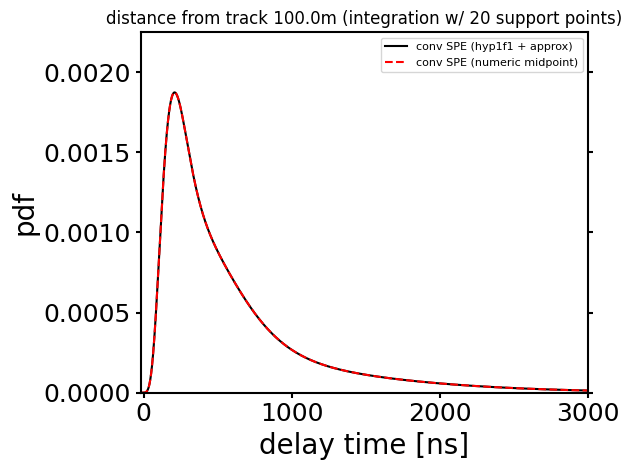

In [19]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 3000, 100000)

y_max = 0


ys = convolved_spe_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv SPE (hyp1f1 + approx)', color='black', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

ys = convolved_spe_numeric_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv SPE (numeric midpoint)', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-20, 3000],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [21]:
%timeit convolved_spe_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))

38.1 ms ± 37.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit convolved_spe_numeric_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))

2.6 ms ± 26 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
